## Local deploying and serving 
Servir et interroger des modèles localement est très simple et peut être effectué en ligne de commande. Si vous souhaitez simplement servir le dernier modèle, vous pouvez le faire en utilisant l'ID du run .

Avant de commencer, accédez à nouveau à l'interface utilisateur de MLFlow et cliquez sur l'expérience scikit_learn_experiment. Choisissez une exécution et copiez l'ID de l'exécution. N'oubliez pas non plus le nom du modèle avec lequel vous avez enregistré le modèle, qui devrait être log_reg_model. 


In [2]:
import pandas as pd
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix
import numpy as np
import subprocess
import json

/home/ewins/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tout d'abord, vous devez remplacer votre répertoire par un répertoire contenant le dossier mlruns avec toutes vos expériences. Ensuite, vous avez besoin de deux choses : l'ID du run de votre modèle et le nom de votre modèle. 

Une fois vous aurez ces information, exécutez cette commande:

> mlflow models serve --model-uri runs:/YOUR_MODEL_RUN/YOUR_MODEL_NAME -p 1235

MLFlow devrait commencer à construire immédiatement un nouvel environnement conda qu'il utilisera pour servir localement. Dans cet environnement, il installe des packages de base et des packages spécifiques que le modèle doit pouvoir s'exécuter.

notre modèle est servi sur : http://localhost:1235/ 

### Interroger le modèle 

Vous êtes maintenant prêt à interroger le modèle avec des données et à recevoir des prédictions. C'est là qu'intervient le module subprocess (ou requests). Tout d'abord, chargeons à nouveau notre dataframe. Exécutez le code suivant : 

#### Interrogation en utilisant subprocess

In [3]:
df = pd.read_csv("data/creditcard.csv")

In [29]:
#input_json = df.iloc[:80].drop(["Time", "Class"],axis=1).to_json(orient="split")

# nous allons extraire 80 valeur pour interroger mle modèle avec 

In [42]:
import json
data_to_send = df.iloc[:80].drop(["Time", "Class"], axis=1)

input_dict = {"dataframe_split": data_to_send.to_dict(orient="split")}

input_json = json.dumps(input_dict)

In [44]:
proc = subprocess.run(["curl", "-X", "POST", "-H","Content-Type:application/json",
"--data", input_json, "http://127.0.0.1:1235/invocations"],
stdout=subprocess.PIPE, encoding='utf-8')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44913  100   257  100 44656   7630  1294k --:--:-- --:--:-- --:--:-- 1329k


In [46]:
output = proc.stdout
df2 = pd.DataFrame([json.loads(output)])
df2

,predictions
0,"[1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ..."


#### Interrogation en utilisant requests 

In [47]:
import requests 

In [48]:
import requests

host = '127.0.0.1'
port = '1235'

url = f'http://{host}:{port}/invocations'

headers = {
    'Content-Type': 'application/json',
}
r = requests.post(url=url, headers=headers, data=input_json)

print(f'Predictions: {r.text}')

Predictions: {"predictions": [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]}


ce que nous avons fait en haut (subprocess ou request) est équivalent à exécuter la commande ci-dessous sur l'invité de commande:

> curl -X POST -H "Content-Type:application/json;
format=pandas-split"
–data "CONTENT_OF_INPUT_JSON"
"http://127.0.0.1:1235/invocations"

Le cœur du problème est que si vous exécutez cela en ligne de commande, coller les données au format JSON peut devenir très compliqué car il y a tellement de colonnes. C'est pourquoi nous avons choisi d'utiliser subprocess ou requests car il est plus facile de transmettre directement le JSON lui-même en utilisant un nom de variable, input_json dans ce cas, pour contenir le contenu du JSON. 

#### Batch querying 

Malheureusement, il y a un maximum d'enregistrements qu'on peut envoyer pour la prédiction (presque 80).

Afin de remédier à ce problème, nous pouvons essayer de batcher nos données et faire une prédiction à chaque batch de données.

nous allons refaire la même chose avec scaling.

In [68]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]
normal_train, normal_test = train_test_split(normal,
test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Time", "Class"],
axis=1))
test = df.iloc[:8000]
true = test.Class
test = scaler.transform(test.drop(["Time", "Class"], axis=1))
preds = []
batch_size = 80
for f in range(100):
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size])
    sample = {"dataframe_split": sample.to_dict(orient="split")}
    input_json = json.dumps(sample)
    
    proc = subprocess.run(["curl", "-X", "POST", "-H","Content-Type:application/json", "--data",input_json, "http://127.0.0.1:1235/invocations"],stdout=subprocess.PIPE,encoding='utf-8')
    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))
    
flattened_data = [item for sublist in preds for item in sublist]
preds = pd.Series(flattened_data)

eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49310  100   257  100 49053  56273  10.2M --:--:-- --:--:-- --:--:-- 11.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49159  100   257  100 48902  55796  10.1M --:--:-- --:--:-- --:--:-- 11.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49079  100   257  100 48822  56458  10.2M --:--:-- --:--:-- --:--:-- 11.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49200  100   257  100 48943  57752  10.4M --:--:-- --:--:-- --:--:-- 11.7M
  % Total    % Received % Xferd  Average Speed   Tim

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49162  100   257  100 48905  48253  8967k --:--:-- --:--:-- --:--:-- 9601k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49025  100   257  100 48768  53776  9965k --:--:-- --:--:-- --:--:-- 11.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49148  100   257  100 48891  49518  9199k --:--:-- --:--:-- --:--:-- 9599k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49169  100   257  100 48912  50421  9371k --:--:-- --:--:-- --:--:-- 11.7M
  % Total    % Received % Xferd  Average Speed   Tim

100 48889  100   257  100 48632  42200  7798k --:--:-- --:--:-- --:--:-- 9548k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48828  100   257  100 48571  41531  7665k --:--:-- --:--:-- --:--:-- 9536k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48871  100   257  100 48614  27928  5159k --:--:-- --:--:-- --:--:-- 5302k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48824  100   257  100 48567  49873  9204k --:--:-- --:--:-- --:--:-- 9535k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48938  100   257  100 48681  46223  8550k --:--:

Eval Acc 0.999625
Eval AUC 0.94


Ici, vous sélectionnez les 8 000 premiers échantillons du dataframe. Étant donné que la taille du lot est de 80, vous avez 100 lots que vous transmettez au modèle 

Text(0.5, 1.0, 'Confusion Matrix')

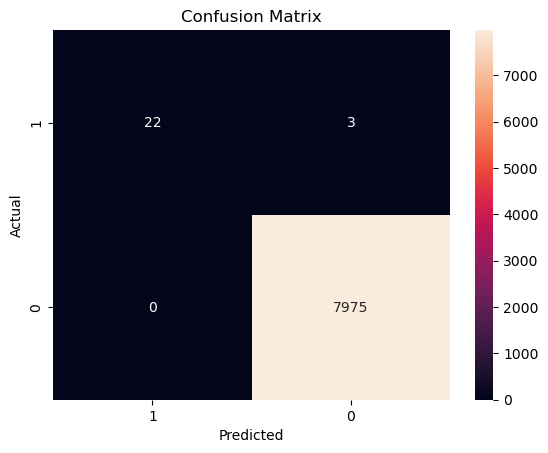

In [69]:
conf_matrix = confusion_matrix(true, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")

In [70]:
!pip show mlflow

Name: mlflow
Version: 2.7.1
Summary: MLflow: A Platform for ML Development and Productionization
Home-page: https://mlflow.org/
Author: Databricks
Author-email: 
License: Apache License 2.0
Location: /home/ewins/anaconda3/lib/python3.9/site-packages
Requires: alembic, click, cloudpickle, databricks-cli, docker, entrypoints, Flask, gitpython, gunicorn, importlib-metadata, Jinja2, markdown, matplotlib, numpy, packaging, pandas, protobuf, pyarrow, pytz, pyyaml, querystring-parser, requests, scikit-learn, scipy, sqlalchemy, sqlparse
Required-by: 
